<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020/blob/main/LSTM_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict function sin(x) with noise**

Original code:
https://github.com/leventguner/lstm-time-series/blob/master/LSTM_time_series.ipynb 

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [48]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    dataset: whole dataset (np array)
    target: target column of whole dataset (put dataset if it has single variable) (np array)
    start_index: starting index of the dataset
    end_index: ending index of the dataset (put None if end index is the last element of dataset)
    history_size: how many data points should appear in past history
    target_size: how many data points you want to predict for future
    step: step size
    single_step: is single step
    """
    
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [49]:
#added = np.concatenate((0*np.arange(250), 0.01*np.arange(50)))

dataset = np.sin(np.arange(300)) + np.random.rand(300)*0.5 # + added #create a sinusoidal dataset with some randomness
dataset = dataset.reshape(len(dataset),1)
dataset[:5]

array([[ 0.33624377],
       [ 0.86021831],
       [ 1.20429667],
       [ 0.57390885],
       [-0.31388527]])

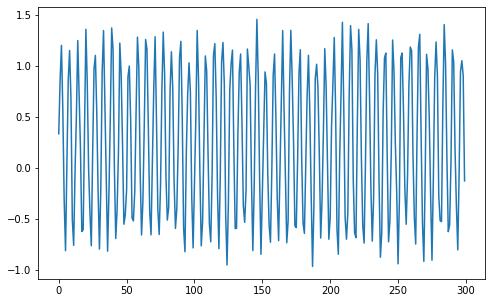

In [50]:
plt.figure(figsize=(8,5))
plt.plot(dataset)

In [51]:
#scale the data
sca = MinMaxScaler()
dataset = sca.fit_transform(dataset)

In [52]:
#train-test split and prepare data for time series

TRAIN_SPLIT = int(len(dataset)*0.7) #how many data in train
past_history = 10 #how many data to look in the past for prediction
future_target = 1 #how many data to predict in the future
STEP = 1 #step size

X_train, y_train = multivariate_data(dataset, dataset[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

X_test, y_test = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT,
                                             None, past_history,
                                             future_target, STEP)
print(X_train.shape)

#reshape dataset in case of need
if len(X_train.shape)==2:
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    
if len(X_test.shape)==2:
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

(200, 10, 1)


In [53]:
X_train.shape, y_train.shape

((200, 10, 1), (200, 1))

In [54]:

model = keras.Sequential()
model.add(keras.layers.LSTM(8, input_shape=(X_train.shape[1],X_train.shape[2])))
#model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(y_train.shape[1]))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(
        X_train, y_train, 
        epochs=70, 
        batch_size=4, 
        validation_split=0.1, 
        verbose=1, 
        shuffle=False
        )

Epoch 1/70
45/45 [==============================] - 2s 18ms/step - loss: 0.4742 - val_loss: 0.2466
Epoch 2/70
45/45 [==============================] - 0s 3ms/step - loss: 0.1773 - val_loss: 0.1089
Epoch 3/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0935 - val_loss: 0.0924
Epoch 4/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0908 - val_loss: 0.0915
Epoch 5/70
45/45 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.0903
Epoch 6/70
45/45 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0891
Epoch 7/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0873 - val_loss: 0.0878
Epoch 8/70
45/45 [==============================] - 0s 3ms/step - loss: 0.0862 - val_loss: 0.0866
Epoch 9/70
45/45 [==============================] - 0s 3ms/step - loss: 0.0850 - val_loss: 0.0853
Epoch 10/70
45/45 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0840
Epoch 11/70
45/45 

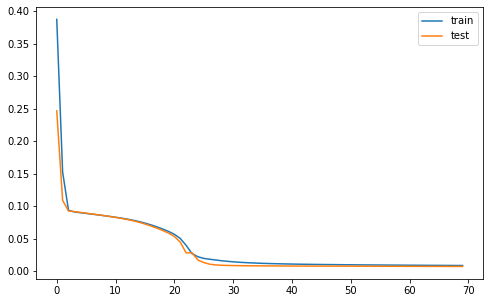

In [56]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
y_pred = model.predict(X_test)

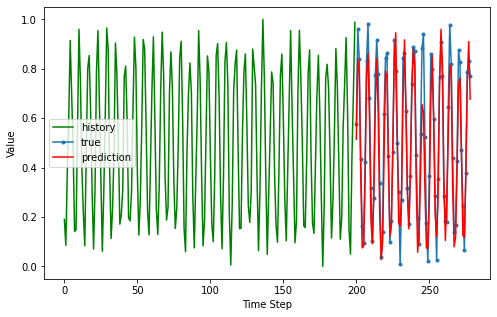

In [58]:
plt.figure(figsize=(8,5))

plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

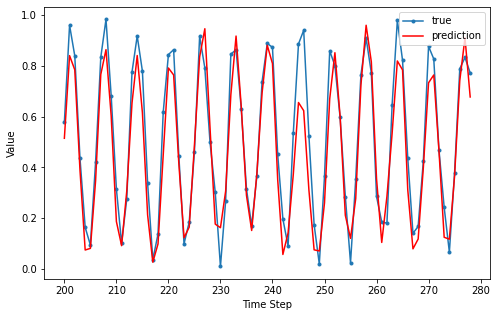

In [59]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();